<a href="https://colab.research.google.com/github/Laballee/Deep-learning-fundamentals/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [241]:
pip install pandas numpy matplotlib statsmodels scipy

In [242]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error

**Load Data**

In [243]:
data = pd.read_csv("MMM.csv")
data = data.dropna()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-03,0.0,4.187500,4.085938,4.187500,0.719247,422400
1,1962-01-04,0.0,4.257813,4.187500,4.187500,0.719247,212800
2,1962-01-05,0.0,4.171875,4.062500,4.078125,0.700461,315200
3,1962-01-08,0.0,4.085938,4.031250,4.054688,0.696436,334400
4,1962-01-09,0.0,4.085938,4.039063,4.054688,0.696436,315200


In [244]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
15570,2023-11-09,92.580002,93.209999,91.650002,91.699997,91.699997,2124200
15571,2023-11-10,92.000000,93.059998,91.660004,92.809998,92.809998,2395000
15572,2023-11-13,92.699997,93.129997,91.919998,92.690002,92.690002,2133200
15573,2023-11-14,94.000000,95.489998,93.930000,94.970001,94.970001,3321400
15574,2023-11-15,95.440002,97.199997,95.440002,96.820000,96.820000,3789500


In [245]:
print(data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


**Data Preprocess and Visualization**

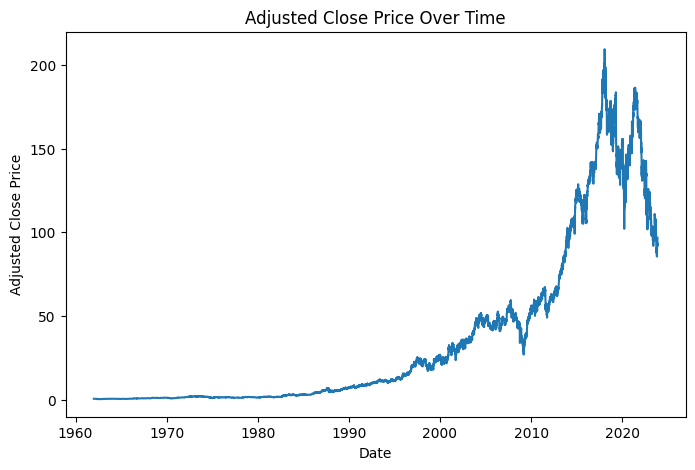

In [246]:
# Convert the 'Date' column to a datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the data as a time series with the date as the index
data.set_index('Date', inplace=True)

# Plot the chart for adjusted closing prices over time
plt.figure(figsize=(8, 5))
plt.plot(data['Adj Close'])
plt.title('Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

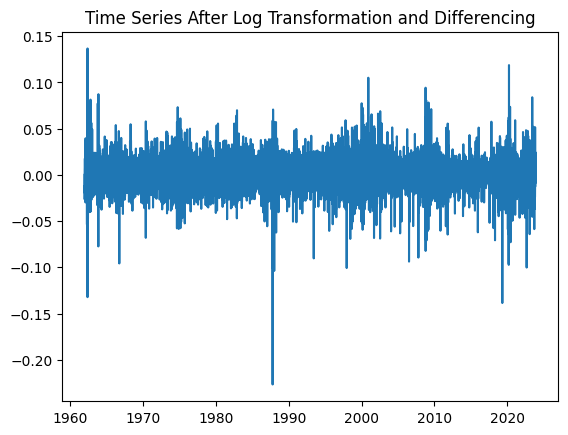

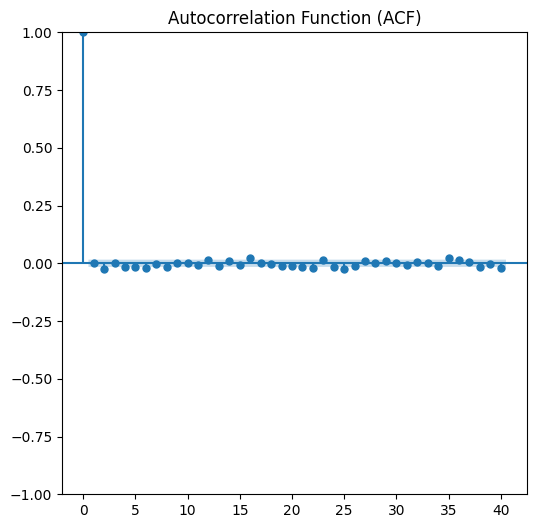

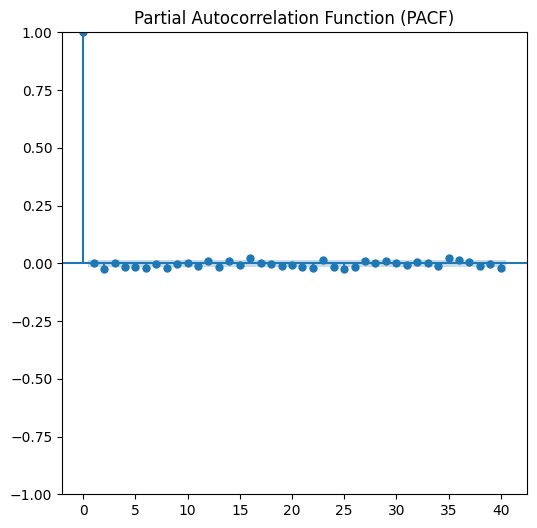

In [247]:
# Converting the 'Adj Close' values to a time series data
data['log_adj_close'] = np.log(data['Adj Close'])

# Calculate the difference (residual) of the log-transformed 'Close' prices
data['differenced'] = data['log_adj_close'].diff()
data = data.iloc[1:]

# Plot the chart for differenced log-transformed closing prices
plt.plot(data['differenced'])
plt.title('Time Series After Log Transformation and Differencing')
plt.show()

# Plot the Autocorrelation Function (ACF)
fig, ax = plt.subplots(figsize=(6, 6))
plot_acf(data['differenced'].dropna(), ax=ax, lags=40)
plt.title('Autocorrelation Function (ACF)')

# Plot the Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(figsize=(6, 6))
plot_pacf(data['differenced'].dropna(), ax=ax, lags=40)
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()


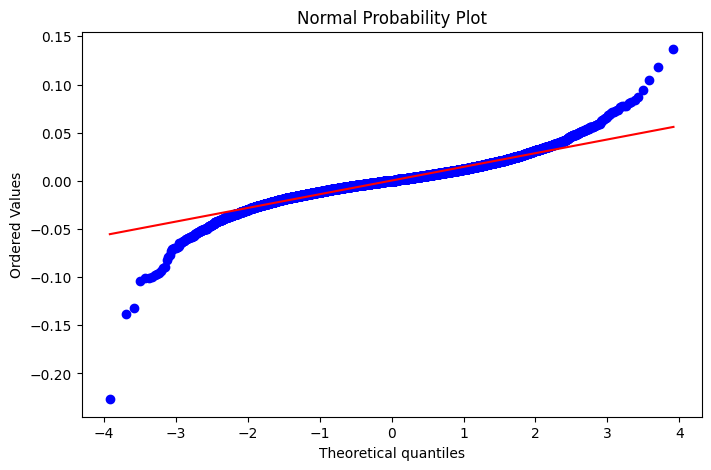

In [248]:
plt.figure(figsize=(8, 5))
# Create a normal probability plot using the differenced data
stats.probplot(data['differenced'].dropna(), dist='norm', plot=plt)
plt.title('Normal Probability Plot')
plt.show()


In [249]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15574 entries, 1962-01-04 to 2023-11-15
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           15574 non-null  float64
 1   High           15574 non-null  float64
 2   Low            15574 non-null  float64
 3   Close          15574 non-null  float64
 4   Adj Close      15574 non-null  float64
 5   Volume         15574 non-null  int64  
 6   log_adj_close  15574 non-null  float64
 7   differenced    15574 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.1 MB


In [250]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,log_adj_close,differenced
count,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,1.557400e+04,15574.000000,15574.000000
mean,51.845376,52.887989,51.987966,52.449100,36.294632,1.974551e+06,2.314452,0.000315
std,58.896203,58.816848,57.920290,58.379314,49.898911,2.010767e+06,1.806886,0.014664
min,0.000000,2.765625,2.570313,2.640625,0.454929,1.760000e+04,-0.787614,-0.226709
25%,7.359375,7.421875,7.296875,7.359375,1.724235,5.296000e+05,0.544783,-0.007055
50%,25.062500,25.187500,24.890625,25.031250,10.499398,1.630500e+06,2.351318,0.000000
75%,80.317499,81.147501,79.647501,80.449997,49.206382,2.763275e+06,3.896023,0.007807
max,258.510010,259.769989,255.970001,258.630005,209.277298,5.053240e+07,5.343660,0.136629


In [251]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Select other variables as features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
data['log_volume'] = np.log(data['Volume'])  # Log transform the 'Volume' variable

# Convert the data to numpy arrays
X = np.array(data[features])
y = np.array(data['differenced'])

# Normalize the data
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Create features with past time points and target variable
def create_dataset(dataset_X, dataset_y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset_X)-look_back-1):
        a = dataset_X[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset_y[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 10
X, y = create_dataset(X_scaled, y_scaled, look_back)

# Split the data into training, validation, and test sets
train_size = int(len(X) * 0.8)
valid_size = int(len(X) * 0.1)
test_size = len(X) - train_size - valid_size

trainX, trainY = X[0:train_size, :], y[0:train_size]
validX, validY = X[train_size:train_size + valid_size, :], y[train_size:train_size + valid_size]
testX, testY = X[train_size + valid_size:len(X), :], y[train_size + valid_size:]

# Reshape the input data to meet the requirements of the RNN input shape
trainX = np.reshape(trainX, (trainX.shape[0], look_back, len(features)))
validX = np.reshape(validX, (validX.shape[0], look_back, len(features)))
testX = np.reshape(testX, (testX.shape[0], look_back, len(features)))


In [252]:
print("Shape of trainX:", trainX.shape)
print("Shape of validX:", validX.shape)

Shape of trainX: (12450, 10, 5)
Shape of validX: (1556, 10, 5)


**Build the RNN mode**

In [253]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(look_back, len(features)), activation='tanh'))
model.add(Dropout(0.2))  # Add a Dropout layer
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
epochs = 40
history = model.fit(trainX, trainY, epochs=epochs, batch_size=32, verbose=2, validation_data=(validX, validY))

# Predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)

Epoch 1/40
390/390 - 6s - loss: 0.0319 - val_loss: 0.0084 - 6s/epoch - 14ms/step
Epoch 2/40
390/390 - 2s - loss: 0.0092 - val_loss: 0.0087 - 2s/epoch - 4ms/step
Epoch 3/40
390/390 - 2s - loss: 0.0086 - val_loss: 0.0092 - 2s/epoch - 5ms/step
Epoch 4/40
390/390 - 2s - loss: 0.0078 - val_loss: 0.0124 - 2s/epoch - 4ms/step
Epoch 5/40
390/390 - 3s - loss: 0.0078 - val_loss: 0.0079 - 3s/epoch - 7ms/step
Epoch 6/40
390/390 - 2s - loss: 0.0077 - val_loss: 0.0063 - 2s/epoch - 6ms/step
Epoch 7/40
390/390 - 2s - loss: 0.0076 - val_loss: 0.0059 - 2s/epoch - 5ms/step
Epoch 8/40
390/390 - 2s - loss: 0.0074 - val_loss: 0.0069 - 2s/epoch - 5ms/step
Epoch 9/40
390/390 - 2s - loss: 0.0072 - val_loss: 0.0070 - 2s/epoch - 5ms/step
Epoch 10/40
390/390 - 2s - loss: 0.0071 - val_loss: 0.0056 - 2s/epoch - 5ms/step
Epoch 11/40
390/390 - 2s - loss: 0.0071 - val_loss: 0.0047 - 2s/epoch - 5ms/step
Epoch 12/40
390/390 - 2s - loss: 0.0070 - val_loss: 0.0042 - 2s/epoch - 6ms/step
Epoch 13/40
390/390 - 2s - loss: 0.0

In [254]:
# Inverse transform the scaled predicted results
trainPredict = scaler_y.inverse_transform(trainPredict)
trainY = scaler_y.inverse_transform([trainY])
validPredict = scaler_y.inverse_transform(validPredict)
validY = scaler_y.inverse_transform([validY])
testPredict = scaler_y.inverse_transform(testPredict)
testY = scaler_y.inverse_transform([testY])

# Calculate the RMSE for the training set, validation set, and test set
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
validScore = np.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print(f'Train RMSE: {trainScore:.4f}')
print(f'Validation RMSE: {validScore:.4f}')
print(f'Test RMSE: {testScore:.4f}')

Train RMSE: 0.0148
Validation RMSE: 0.0111
Test RMSE: 0.0170


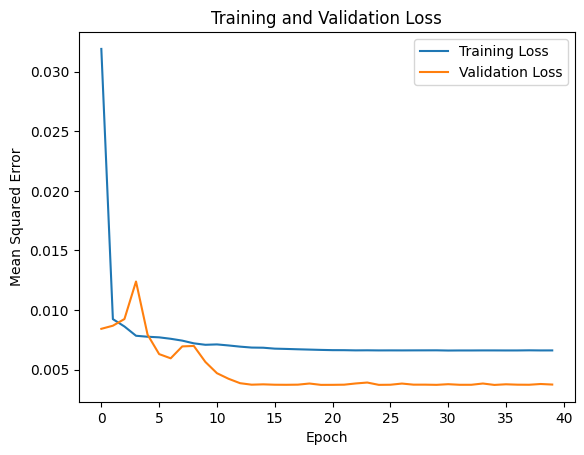

In [255]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and legend
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

49/49 [==============================] - 0s 4ms/step


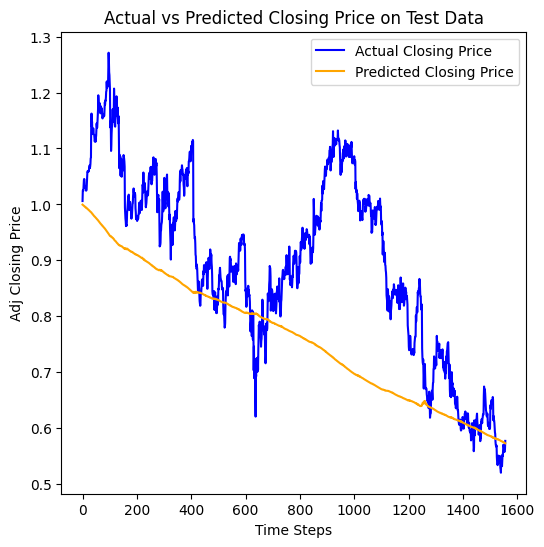

In [270]:
# Normalize each feature
testX_scaled = np.zeros_like(testX)
for i in range(testX.shape[-1]):
    testX_scaled[:,:,i] = scaler_X.fit_transform(testX[:,:,i])

testX_scaled_reshaped = np.reshape(testX_scaled, (testX_scaled.shape[0], testX_scaled.shape[1], testX_scaled.shape[2]))

# Make predictions
testPredict_scaled = model.predict(testX_scaled_reshaped)

# Inverse normalize the predicted results
testPredict_original_diff = scaler_y.inverse_transform(testPredict_scaled)

# Apply the inverse exponential transformation
testPredict_original_log = np.exp(testPredict_original_diff.cumsum())

# Apply inverse exponential transformation to the true labels
testY_original_log = np.exp(testY.cumsum())

# Plot the results
plt.figure(figsize=(6, 6))
plt.plot(testY_original_log, label='Actual Closing Price', color='blue')
plt.plot(testPredict_original_log, label='Predicted Closing Price', color='orange')
plt.title('Actual vs Predicted Closing Price on Test Data')
plt.xlabel('Time Steps')
plt.ylabel('Adj Closing Price')
plt.legend()
plt.show()

**Build LSTM model**

In [258]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

look_back = 10
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, len(features)), activation='tanh'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Reshape target data
trainY = trainY.reshape(-1, 1)
validY = validY.reshape(-1, 1)
testY = testY.reshape(-1, 1)

# Train LSTM model
epochs = 40
history_lstm = model_lstm.fit(trainX, trainY, epochs=epochs, batch_size=32, verbose=2, validation_data=(validX, validY))

# Predictions
trainPredict_lstm = model_lstm.predict(trainX)
validPredict_lstm = model_lstm.predict(validX)
testPredict_lstm = model_lstm.predict(testX)


Epoch 1/40
390/390 - 6s - loss: 0.0029 - val_loss: 2.2793e-04 - 6s/epoch - 15ms/step
Epoch 2/40
390/390 - 3s - loss: 3.0115e-04 - val_loss: 3.2365e-04 - 3s/epoch - 9ms/step
Epoch 3/40
390/390 - 4s - loss: 2.8079e-04 - val_loss: 2.9927e-04 - 4s/epoch - 10ms/step
Epoch 4/40
390/390 - 3s - loss: 2.5193e-04 - val_loss: 2.8218e-04 - 3s/epoch - 8ms/step
Epoch 5/40
390/390 - 3s - loss: 2.5798e-04 - val_loss: 2.9968e-04 - 3s/epoch - 8ms/step
Epoch 6/40
390/390 - 3s - loss: 2.4472e-04 - val_loss: 2.7839e-04 - 3s/epoch - 8ms/step
Epoch 7/40
390/390 - 4s - loss: 2.4249e-04 - val_loss: 1.5681e-04 - 4s/epoch - 11ms/step
Epoch 8/40
390/390 - 3s - loss: 2.4544e-04 - val_loss: 1.5760e-04 - 3s/epoch - 8ms/step
Epoch 9/40
390/390 - 3s - loss: 2.4213e-04 - val_loss: 2.9175e-04 - 3s/epoch - 8ms/step
Epoch 10/40
390/390 - 3s - loss: 2.3963e-04 - val_loss: 1.4423e-04 - 3s/epoch - 8ms/step
Epoch 11/40
390/390 - 4s - loss: 2.3410e-04 - val_loss: 1.3400e-04 - 4s/epoch - 10ms/step
Epoch 12/40
390/390 - 3s - los

In [259]:
# Inverse transform the scaled predicted results for LSTM
trainPredict_lstm = scaler_y.inverse_transform(trainPredict_lstm)
trainY_lstm = scaler_y.inverse_transform(trainY.reshape(-1, 1))
validPredict_lstm = scaler_y.inverse_transform(validPredict_lstm)
validY_lstm = scaler_y.inverse_transform(validY.reshape(-1, 1))
testPredict_lstm = scaler_y.inverse_transform(testPredict_lstm)
testY_lstm = scaler_y.inverse_transform(testY.reshape(-1, 1))

# Calculate the RMSE for the training set, validation set, and test set for LSTM
trainScore_lstm = np.sqrt(mean_squared_error(trainY_lstm, trainPredict_lstm[:, 0]))
validScore_lstm = np.sqrt(mean_squared_error(validY_lstm, validPredict_lstm[:, 0]))
testScore_lstm = np.sqrt(mean_squared_error(testY_lstm, testPredict_lstm[:, 0]))

# Print the RMSE for each set for LSTM
print(f'Train RMSE (LSTM): {trainScore_lstm:.4f}')
print(f'Validation RMSE (LSTM): {validScore_lstm:.4f}')
print(f'Test RMSE (LSTM): {testScore_lstm:.4f}')

Train RMSE (LSTM): 0.0027
Validation RMSE (LSTM): 0.0021
Test RMSE (LSTM): 0.0031


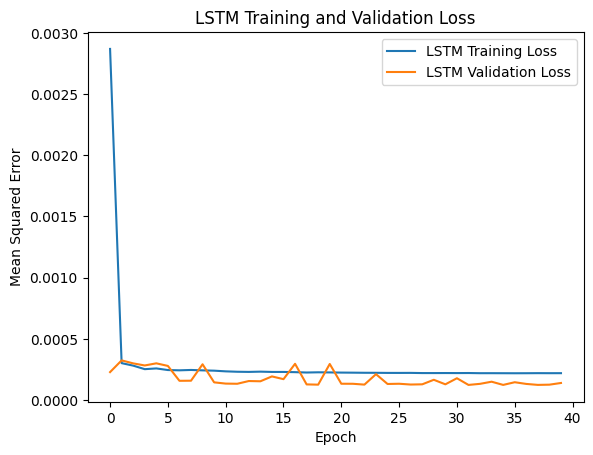

In [260]:
# Plot the training and validation loss curves for LSTM
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')

# Add labels and legend
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

49/49 [==============================] - 0s 6ms/step


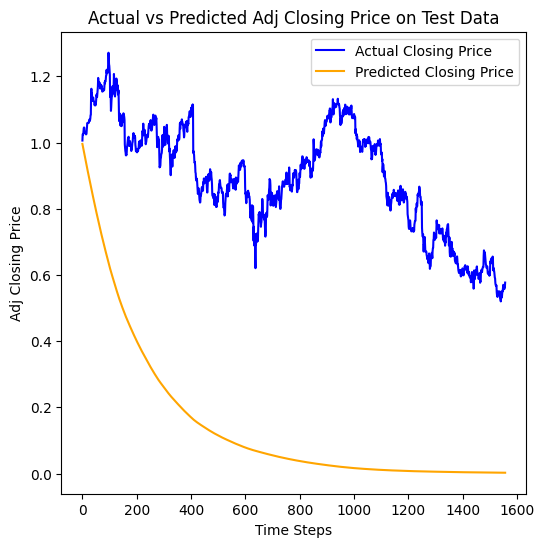

In [271]:
# Make predictions
testPredict_scaled = model_lstm.predict(testX)

# Apply the inverse exponential transformation
testPredict_original_log = np.exp(testPredict_scaled.cumsum())

# Apply inverse exponential transformation to the true labels
testY_original_log = np.exp(testY.cumsum())

# Plot the results
plt.figure(figsize=(6, 6))
plt.plot(testY_original_log, label='Actual Closing Price', color='blue')
plt.plot(testPredict_original_log, label='Predicted Closing Price', color='orange')
plt.title('Actual vs Predicted Adj Closing Price on Test Data')
plt.xlabel('Time Steps')
plt.ylabel('Adj Closing Price')
plt.legend()
plt.show()

**Build GRU model**

In [264]:
from keras.layers import GRU

model_gru = Sequential()
model_gru.add(GRU(50, input_shape=(look_back, len(features)), activation='tanh'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

# Train GRU model
history_gru = model_gru.fit(trainX, trainY, epochs=epochs, batch_size=32, verbose=2, validation_data=(validX, validY))

# Predictions
trainPredict_gru = model_gru.predict(trainX)
validPredict_gru = model_gru.predict(validX)
testPredict_gru = model_gru.predict(testX)


Epoch 1/40
390/390 - 7s - loss: 0.0096 - val_loss: 6.5990e-04 - 7s/epoch - 19ms/step
Epoch 2/40
390/390 - 4s - loss: 5.0161e-04 - val_loss: 7.7897e-04 - 4s/epoch - 9ms/step
Epoch 3/40
390/390 - 3s - loss: 3.5958e-04 - val_loss: 7.4138e-04 - 3s/epoch - 8ms/step
Epoch 4/40
390/390 - 3s - loss: 3.0887e-04 - val_loss: 6.7764e-04 - 3s/epoch - 8ms/step
Epoch 5/40
390/390 - 3s - loss: 3.0001e-04 - val_loss: 8.5214e-04 - 3s/epoch - 9ms/step
Epoch 6/40
390/390 - 6s - loss: 2.8704e-04 - val_loss: 8.1112e-04 - 6s/epoch - 15ms/step
Epoch 7/40
390/390 - 3s - loss: 2.7412e-04 - val_loss: 5.8977e-04 - 3s/epoch - 8ms/step
Epoch 8/40
390/390 - 3s - loss: 2.6627e-04 - val_loss: 5.9999e-04 - 3s/epoch - 8ms/step
Epoch 9/40
390/390 - 4s - loss: 2.7541e-04 - val_loss: 5.3482e-04 - 4s/epoch - 10ms/step
Epoch 10/40
390/390 - 3s - loss: 2.6396e-04 - val_loss: 2.7019e-04 - 3s/epoch - 9ms/step
Epoch 11/40
390/390 - 3s - loss: 2.6422e-04 - val_loss: 4.0070e-04 - 3s/epoch - 8ms/step
Epoch 12/40
390/390 - 3s - loss

In [265]:
# Inverse transform the scaled predicted results for GRU
trainPredict_gru = scaler_y.inverse_transform(trainPredict_gru)
trainY_gru = scaler_y.inverse_transform(trainY)
validPredict_gru = scaler_y.inverse_transform(validPredict_gru)
validY_gru = scaler_y.inverse_transform(validY)
testPredict_gru = scaler_y.inverse_transform(testPredict_gru)
testY_gru = scaler_y.inverse_transform(testY)

# Calculate the RMSE for the training set, validation set, and test set for GRU
trainScore_gru = np.sqrt(mean_squared_error(trainY_gru, trainPredict_gru[:, 0]))
validScore_gru = np.sqrt(mean_squared_error(validY_gru, validPredict_gru[:, 0]))
testScore_gru = np.sqrt(mean_squared_error(testY_gru, testPredict_gru[:, 0]))

# Print the RMSE for each set for GRU
print(f'Train RMSE (GRU): {trainScore_gru:.4f}')
print(f'Validation RMSE (GRU): {validScore_gru:.4f}')
print(f'Test RMSE (GRU): {testScore_gru:.4f}')


Train RMSE (GRU): 0.0027
Validation RMSE (GRU): 0.0020
Test RMSE (GRU): 0.0031


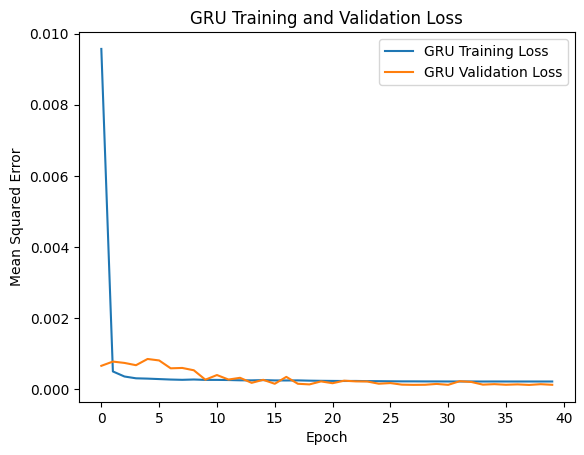

In [266]:
# Plot the training and validation loss curves for GRU
plt.plot(history_gru.history['loss'], label='GRU Training Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss')

# Add labels and legend
plt.title('GRU Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

49/49 [==============================] - 0s 4ms/step


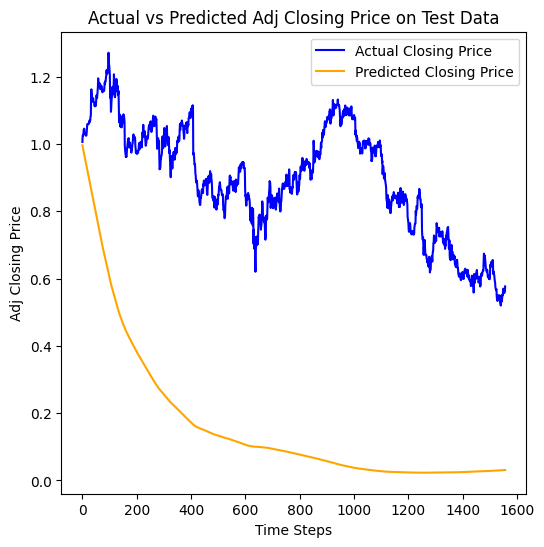

In [273]:
# Make predictions
testPredict_scaled = model_gru.predict(testX)

# Apply the inverse exponential transformation
testPredict_original_log = np.exp(testPredict_scaled.cumsum())

# Apply inverse exponential transformation to the true labels
testY_original_log = np.exp(testY.cumsum())

# Plot the results
plt.figure(figsize=(6, 6))
plt.plot(testY_original_log, label='Actual Closing Price', color='blue')
plt.plot(testPredict_original_log, label='Predicted Closing Price', color='orange')
plt.title('Actual vs Predicted Adj Closing Price on Test Data')
plt.xlabel('Time Steps')
plt.ylabel('Adj Closing Price')
plt.legend()
plt.show()

**Build ARIMA model**

In [268]:
from statsmodels.tsa.arima.model import ARIMA

# Choose a set of possible (p, d, q) values
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_aic = float('inf')
best_order = None

for p in p_values:
  for d in d_values:
    for q in q_values:
      order = (p, d, q)
      try:
          arima_model = ARIMA(y, order=order)
          arima_result = arima_model.fit()
          aic = arima_result.aic
          if aic < best_aic:
              best_aic = aic
              best_order = order
      except:
          continue

print(f'Best Order: {best_order} with AIC: {best_aic}')


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best Order: (0, 0, 2) with AIC: -34173.2351235123


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                15563
Model:                 ARIMA(0, 0, 2)   Log Likelihood               17090.618
Date:                Tue, 21 Nov 2023   AIC                         -34173.235
Time:                        16:14:15   BIC                         -34142.625
Sample:                             0   HQIC                        -34163.097
                              - 15563                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2497      0.001    390.120      0.000       0.248       0.251
ma.L1         -0.0010      0.005     -0.194      0.846      -0.011       0.009
ma.L2         -0.0240      0.005     -4.423      0.0

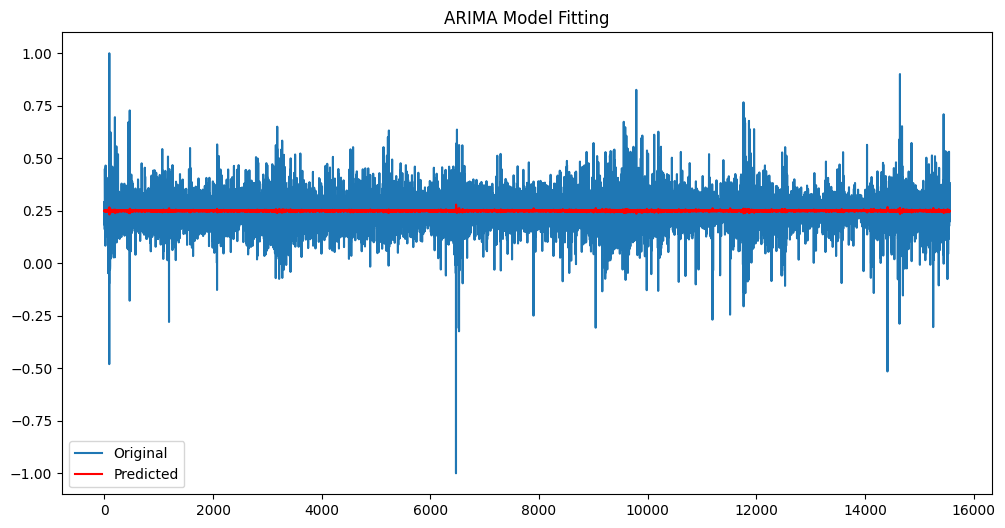

RMSE: 0.08069363600584645


In [269]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Determine the order of the ARIMA model (p, d, q)
p, d, q = 0, 0, 2

# Fit the ARIMA model
arima_model = ARIMA(y, order=(p, d, q))
arima_result = arima_model.fit()

# Print model summary
print(arima_result.summary())

# Plot the comparison of the original data and model predictions
plt.figure(figsize=(12, 6))
plt.plot(y, label='Original')
plt.plot(arima_result.fittedvalues, color='red', label='Predicted')
plt.legend()
plt.title('ARIMA Model Fitting')
plt.show()

# Calculate the RMSE
rmse = mean_squared_error(y, arima_result.fittedvalues, squared=False)
print(f'RMSE: {rmse}')
